In [1]:
# hygese module was not working on my macbook therefore I used google colab
# this install is not needed if hygese is already installed in your environment
!pip install hygese

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Improved Solution 1**

Below you can find our first improvement to the benchmark solution. The imbalance between the holding cost and lost sales was one of the issues we encountered in our benchmark solution. In this solution, we improve upon it by using a larger action space and trying to find a balance. In benchmark solution where we replenished the stores to a level of $2 \times order-up-to$, our model converged to a solution where it mostly replenishes 9 stores. Therefore, in this solution we set a minimum of 5 as the numbers of stores to be replenished each day and therefore reduce the action space. In this solution, we are seeking a better $ratio$ in the replenishment level $ratio \times order-up-to$ while still keeping the action space rather simple.

**Actions**
<br>
We changed the type of output we expect from the REINFORCE algorithm in this solution. While still keeping a discrete action space, we made our model to output not only how many stores to replenish, but also up to what ratio of order-up-to level to replenish at each time t.

$𝑎$ $∈$ $𝒜(𝑆_{𝑡})$, where $𝐴_{𝑡}$ $∈$ $𝒜(𝑆_{𝑡})$ is a realized action at time $𝑡$. In our case, the actions are integers in the range $[0, 75]$ for each state. After model outputs an integer in this range, we then map this integer to:
<br>
number of stores to replenish = output % 15 + 5
<br>
up_to_ratio = ((action // 15)/4) + 1
<br>
We set a minimum 5 indicating the minimum number of stores to replenish each day. 

**Policy**
<br>
Once the decision is made by the model, we will sort the stores, depending on how far their inventories are from the corresponding demand means. Then, the first N stores that are farthest from their demand means will be replenished to an order up to level. Then, the resulting stores that have less inventory are replenished to $ratio \times order-up-to$.
<br> <br>
The above mentioned policy is implemented in $takeAction$ function in the gym environment.

In [2]:
# importing the necessary libraries
import gym
from gym import spaces
import numpy as np
import hygese as hgs
import geopy.distance
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# enable cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Solver initialization
ap = hgs.AlgorithmParameters(timeLimit=0.1)  # seconds
hgs_solver = hgs.Solver(parameters=ap, verbose=False)

class AI4LEnvironment(gym.Env):
    """Joint Replenishment Environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    # initialization
    def __init__(self):
        super().__init__()
        # number of stores
        self.nStores = 19
        # data dictionary, needed for hygese solver
        self.data = dict()
        self.lat = np.array([51.46455753,  # arbitrarily selected as depot
                             51.48315348,
                             51.47946524,
                             51.47989288,
                             51.47091165,
                             51.46823832,
                             51.45097352,
                             51.44236109,
                             51.44075611,
                             51.43310493,
                             51.42748611,
                             51.44209359,
                             51.41860162,
                             51.41196388,
                             51.41919040,
                             51.45204327,
                             51.47407462,
                             51.46455753,
                             51.41655806,
                             51.46071441
                             ])

        self.lon = np.array([5.441001338,  # arbitrarily selected as depot
                             5.449615716,
                             5.463520286,
                             5.478883978,
                             5.463348625,
                             5.47776818,
                             5.465205594,
                             5.47979681,
                             5.471642895,
                             5.489753169,
                             5.465033933,
                             5.408385679,
                             5.407870695,
                             5.409587309,
                             5.441001338,
                             5.517476483,
                             5.546744746,
                             5.550177973,
                             5.572865385,
                             5.609406608
                             ])

        # initializing the distance matrix
        self.data['distance_matrix'] = np.zeros(shape=[self.nStores + 1, self.nStores + 1])
        # transportation unit cost
        self.transportCost = 2.5
        # transportation fixed cost
        self.fixedTransportCost = 20

        # calculating the distance matrix that reflects the cost of transportation from a location to another  
        for i in range(0, self.nStores + 1):
            for j in range(0, self.nStores + 1):
                coords_1 = (self.lat[i], self.lon[i])
                coords_2 = (self.lat[j], self.lon[j])
                self.data['distance_matrix'][i][j] = geopy.distance.geodesic(coords_1, coords_2).km * self.transportCost
                if i == 0:
                    self.data['distance_matrix'][i][j] += self.fixedTransportCost
        # we copy the original version of this distance matrix
        # it will be used later to filter the locations for hygese solver
        self.DISTANCE_MATRIX = self.data['distance_matrix'].copy()
        # service times are asssumed to be 0
        self.data['service_times'] = np.zeros(self.nStores + 1)
        # the vehicle capacity, the number of vehicles, and depot information
        # this is stored in the 'data' dict to be compatible with hygese solver
        self.data['vehicle_capacity'] = 100
        self.data['num_vehicles'] = 19
        self.data['depot'] = 0
        # holding cost
        self.c_holding = 1
        # loss sales cost
        self.c_lost = 19
        # capacity of each store
        self.capacity = 1000
        # The maximum to be shipped to a store
        self.maxOrderQuantity = 1000
        # the current amount of inventory in each store
        self.inventories = np.zeros(self.nStores + 1)
        # information on the demand distribution
        # small, medium or large stores: 4, 10, 25 shape par.
        self.demandMean = np.array([0,  # fake depot entry to let indices match
                                    10,
                                    4,
                                    10,
                                    10,
                                    25,
                                    25,
                                    4,
                                    25,
                                    25,
                                    25,
                                    4,
                                    10,
                                    4,
                                    10,
                                    10,
                                    4,
                                    4,
                                    10,
                                    4])
        self.data['demands'] = self.demandMean.copy()
        np.random.seed(1331)
        # standard deviations for the normal distribuiton
        self.demandStdev = np.ceil(np.random.rand(self.nStores + 1) * 0.5 * self.demandMean)
        # create some fixed order up to levels
        self.orderUpTo = np.ceil(self.demandMean + 1.96 * np.sqrt(self.demandStdev))
        # for this case, action space is defined as the number of stores to replenish given a state
        # we set a minimum of 5 stores to be replenished each day to speed up training
        self.action_space = spaces.Discrete(75)
        # observation space is simply the inventory levels at each store at the start of the day
        self.observation_space = spaces.Box(low=0,
                                            high=self.capacity,
                                            shape=(self.nStores + 1,),
                                            dtype=np.int)
        # analytics for bookkeeping purposes
        self.transportCost, self.holdingCost, self.lossSales = [], [], []
        self.counter, self.holdCost, self.salesLoss, self.tCost = 0, 0, 0, 0

    def calcDirectReward(self, ind):
        # ind: indices of the stores that are going to be replenished
        # hygese solver does not cover the edge cases and throw NULL pointer error.
        # therefore we cover those cases by if-else statements to avoid error.
        # warehouse is always in the ind
        if len(ind) == 1: 
            # cost is 0 if only warehouse in ind
            cost = 0
        elif len(ind) == 2:
            # returning cost of trasnporation between warehouse and the supermarket
            # in the case where we only replenish 1 store
            # as our policy, we never replenish more than 100, therefore only 1 car is needed
            cost = self.DISTANCE_MATRIX[0][ind[1]] + self.DISTANCE_MATRIX[ind[1]][0]
        else:
            # filtering the distance matrix
            # this is crucial, otherwise hygese visits every store
            self.data['distance_matrix'] = np.take(np.take(self.DISTANCE_MATRIX, ind, axis=0), ind, axis=1)
            # solving
            result = hgs_solver.solve_cvrp(self.data)
            # getting the cost
            cost = result.cost
        return -1 * cost

    def step(self, action):
        # taking the action
        ind = self._take_action(action)
        # getting the transportation cost
        reward = self.calcDirectReward(ind)
        self.tCost += reward
        self.current_step += 1

        # generating random demand
        demands = np.zeros(self.nStores+1)
        for i in range(1, self.nStores):
            demands[i] = int(max(0, np.random.normal(self.demandMean[i], self.demandStdev[i])))
            self.inventories[i] -= demands[i]
            holdCost_temp = max(0, self.inventories[i]) * self.c_holding
            self.holdCost += holdCost_temp
            lossSales_temp = -1 * min(0, self.inventories[i]) * self.c_lost
            self.salesLoss += lossSales_temp
            reward -= (holdCost_temp + lossSales_temp)
            self.inventories[i] = max(0, self.inventories[i])
        self.counter += 1
        if self.counter == 100:
            self.holdingCost.append(self.holdCost / 100)
            self.lossSales.append(self.salesLoss / 100)
            self.transportCost.append(-self.tCost / 100)
            self.holdCost, self.salesLoss, self.tCost = 0, 0, 0
            self.counter = 0

        # our episodes consist of 20 days
        done = self.current_step >= 20
        # observed new state is the updated inventories
        obs = self.inventories
        return obs, reward, done, {}


    def _take_action(self, action):
        # in this example it is rather simple; the inventory is shipped
        n_replenish = action % 15 + 5
        up_to_ratio = ((action // 15)/4) + 1
        # calculating the difference between the current inventory and demand means
        deficit = (self.inventories[1:] - self.demandMean[1:])
        # getting the indices that would sort this array and taking the indices of  
        # supermarkets that has the most deficit
        ind = deficit.argsort()[:n_replenish]
        # sorting the indices
        ind.sort()
        actual_ind = [0]
        # copying the inventories before the action
        old_inv = self.inventories.copy()
        # looping over the indices of over stores that are going to be replenished
        for i in ind:
            # ordering if their inventory is smaller than the orderUpTo inventory
            if self.inventories[i+1] < self.orderUpTo[i+1] * up_to_ratio:
                self.inventories[i+1] = self.orderUpTo[i+1] * up_to_ratio
                actual_ind.append(i+1)
        '''self.data['demands'] is not actually demands, but action. hygese solver
        requires it to be called "demands". we are filtering them since we only need
        to consider the stores that we are going to replenish'''
        self.data['demands'] = np.take((self.inventories - old_inv).copy(), actual_ind, axis=0)
        self.data['service_times'] = np.zeros(len(actual_ind))
        # returning the indices of the stores that are going to be replenished
        return actual_ind

    def analytics(self):
        return self.transportCost, self.holdingCost, self.lossSales
        
    def reset(self):
        # reset the state of the environment to an initial state
        # to be more realistic, we are assigning random ineventory between 0 and 10 to each store.
        self.inventories = np.array([0]+list(np.random.randint(low=0, high=11, size=self.nStores)))
        # resetting the step parameter
        self.current_step = 0
        return self.inventories

    def render(self, mode='human', close=False):
        print("No rendering implemented")

Using cpu device


In [3]:
# neural network
class PolicyNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        # dimension of observation space, 20
        self.n_inputs = env.observation_space.shape[0]
        # number of outputs is 20, how many stores to replenish [0, 19] 
        self.n_outputs = env.action_space.n
        # neural network structure
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 256), 
            nn.ReLU(), 
            nn.Linear(256, 64),
            nn.ReLU(), 
            nn.Linear(64, self.n_outputs),
            nn.Softmax(dim=-1))
    # given a state, returns the action probabilities
    def predict(self, state):
        action_probs = self.network(torch.FloatTensor(state).to(device))
        return action_probs

# discounts the rewards with gamma = 0.9
def discount_rewards(rewards, gamma=0.9):
    r = np.array([gamma**i * rewards[i] for i in range(len(rewards))])
    r = r[::-1].cumsum()[::-1]
    return r - r.mean()

# main structure of the REINFORCE algorithm
def reinforce(env, policy_estimator, num_episodes=500, batch_size=10, gamma=0.5):
    # bookkeeping
    total_rewards = []
    avg_rewards = []
    batch_rewards = []
    batch_actions = []
    batch_states = []
    batch_counter = 1
    
    # we will use adam optimizer with a particular learning rate that we optimized
    optimizer = optim.Adam(policy_estimator.network.parameters(), lr=0.001)
    # getting an integer for every action in the action space
    action_space = np.arange(env.action_space.n)
    # setting episode to 0
    ep = 0
    # looping over the number of episodes
    while ep < num_episodes:
        # resetting the state at the beginning of each episode
        s_0 = env.reset()
        # bookkeeping
        states = []
        rewards = []
        actions = []
        done = False
        # looping over until the end of the episode
        while not done:
            # getting the action probabilites
            action_probs = policy_estimator.predict(s_0).detach().cpu().numpy()
            # picking an action from the above prob. distribution
            action = np.random.choice(action_space, p=action_probs)
            # observing the new state and the rewards
            s_1, r, done, _ = env.step(action)
            # bookkeeping
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            s_0 = s_1
            
            # batching if done
            if done:
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                # dividing by 20 since every episode is of length 20
                total_rewards.append(sum(rewards) / 20)
                
                # updating the network once the episode is finished
                if batch_counter == batch_size:
                    # resetting gradients of optimizer to zero 
                    optimizer.zero_grad()
                    # getting the state, reward, and action tensors
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards).to(device)
                    action_tensor = torch.LongTensor(batch_actions).to(device)
                    
                    # calculating the resulting loss
                    logprob = torch.log(policy_estimator.predict(state_tensor))
                    selected_logprobs = reward_tensor * torch.gather(logprob, 1, action_tensor.view(action_tensor.shape[0],1)).squeeze()
                    loss = -selected_logprobs.mean()
                    
                    # calculating backward propagation
                    loss.backward()
                    # updating the gradients
                    optimizer.step()
                    # bookkepping
                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1
                # getting the average reward of the latest 3 episodes
                avg_reward = np.mean(total_rewards[-60:])
                avg_rewards.append(avg_reward)
                print("Ep: {} Average of last 60: {:.2f}".format(ep + 1, avg_reward))
                ep += 1
    return total_rewards, avg_rewards

Ep: 1 Average of last 60: -467.09
Ep: 2 Average of last 60: -493.73
Ep: 3 Average of last 60: -503.18
Ep: 4 Average of last 60: -494.37
Ep: 5 Average of last 60: -487.09
Ep: 6 Average of last 60: -481.69
Ep: 7 Average of last 60: -473.54
Ep: 8 Average of last 60: -493.39
Ep: 9 Average of last 60: -486.77
Ep: 10 Average of last 60: -489.60
Ep: 11 Average of last 60: -483.31
Ep: 12 Average of last 60: -479.61
Ep: 13 Average of last 60: -477.95
Ep: 14 Average of last 60: -477.19
Ep: 15 Average of last 60: -476.07
Ep: 16 Average of last 60: -472.99
Ep: 17 Average of last 60: -468.10
Ep: 18 Average of last 60: -467.19
Ep: 19 Average of last 60: -467.29
Ep: 20 Average of last 60: -468.79
Ep: 21 Average of last 60: -474.96
Ep: 22 Average of last 60: -473.27
Ep: 23 Average of last 60: -473.27
Ep: 24 Average of last 60: -472.35
Ep: 25 Average of last 60: -470.39
Ep: 26 Average of last 60: -470.40
Ep: 27 Average of last 60: -467.73
Ep: 28 Average of last 60: -467.56
Ep: 29 Average of last 60: -4

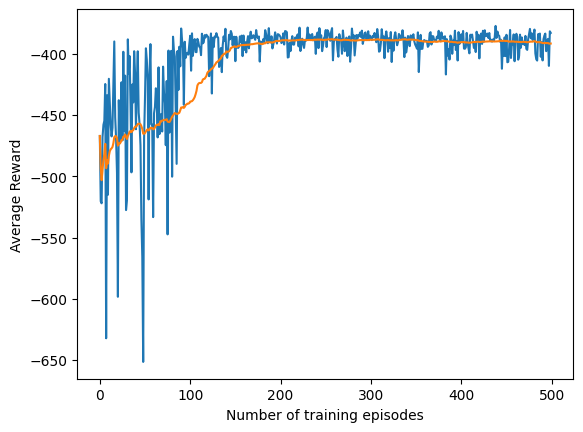

In [4]:
# initializing the environment
env = AI4LEnvironment()
# initializng the model
policy_est = PolicyNet(env).to(device)
# training 
rewards, avg_rewards = reinforce(env, policy_est)
# plotting
plt.plot(rewards)
plt.plot(avg_rewards)
plt.xlabel("Number of training episodes")
plt.ylabel("Average Reward")
plt.savefig('benchmark.png')
plt.show()

In [5]:
# resetting the environment for simulation
env.reset()
# bookkeeping
rewards = []
# 10 episodes, each with 20 days
for _ in range(10):
    obs = env.reset()
    done = False
    while not done:
        # getting the predictions from the trained model
        action_probs = policy_est.predict(obs)
        action = np.random.choice(np.arange(75), p=action_probs.detach().cpu().numpy())
        n_replenish = action % 15 + 5
        up_to_ratio = ((action // 15)/4) + 1
        obs, reward, done, b = env.step(action)
        print("NEW STATE:", obs, "ACTION:", [n_replenish, up_to_ratio], "REWARD:", reward)
        rewards.append(reward)
print(f"Average Reward of the Benchmark Policy = {np.array(rewards).mean()}")

NEW STATE: [ 0 11  6  9 14 15 16  4 15 16 20  5  9 10 14 10  6  6 17  7] ACTION: [18, 1.5] REWARD: -425.3151754632812
NEW STATE: [ 0  6  8  9 13 17 10 10 15 15 15  5  8  9 13 14  7  7  9 10] ACTION: [18, 1.5] REWARD: -374.28226858663237
NEW STATE: [ 0 11  8 10  8 15 27  5 19 14 15 10  7  2 21 10  6  8 17 10] ACTION: [18, 1.5] REWARD: -398.80219686176173
NEW STATE: [ 0  8  4  8 13 13 35  8 12 17 17  3  8  8 18  8  5  5 10 10] ACTION: [18, 1.5] REWARD: -392.79465076330456
NEW STATE: [ 0  6  2  9 12 16  0  3  6 14 32  2  8  7 10 11  5  7 13 10] ACTION: [18, 1.5] REWARD: -434.246312420255
NEW STATE: [ 0  8  6 10  7 15 37  4 25 15 28  8  9  3 10  9  4  6 12 10] ACTION: [18, 1.5] REWARD: -411.52115783786684
NEW STATE: [ 0  7  7  7  9 16 16  8 24 16 19  7 10  5 19  5  4  6 13 10] ACTION: [18, 1.5] REWARD: -361.4638517564787
NEW STATE: [ 0  7  6  9 17 15 41  5 18 16 35  6  9  5 12  8  6  7 15 10] ACTION: [18, 1.5] REWARD: -431.7407794804202
NEW STATE: [ 0  8  5  7 13 15  6  6 18 14 11 10  8  8

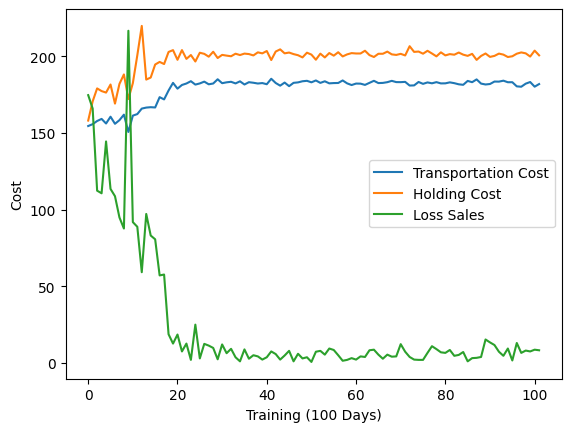

In [6]:
transportCost, holdingCost, lossSales = env.analytics()
# plotting the basic analytics
plt.plot(transportCost, label="Transportation Cost")
plt.plot(holdingCost, label="Holding Cost")
plt.plot(lossSales, label="Loss Sales")
plt.xlabel("Training (100 Days)")
plt.ylabel("Cost")
plt.legend()
plt.show()

In [7]:
print(f"AVERAGE TRANSPORT COST (LAST 500 DAYS): {np.round(np.array(transportCost[-5:]).mean(), 2)}")
print(f"AVERAGE HOLDING COST (LAST 500 DAYS): {np.round(np.array(holdingCost[-5:]).mean(), 2)}")
print(f"AVERAGE LOSS SALES (LAST 500 DAYS): {np.round(np.array(lossSales[-5:]).mean(), 2)}")

AVERAGE TRANSPORT COST (LAST 500 DAYS): 181.46
AVERAGE HOLDING COST (LAST 500 DAYS): 201.67
AVERAGE LOSS SALES (LAST 500 DAYS): 7.71


**Conclusion**
<br>
It can be seen from the above results that similar to the benchmark solution, our model learned to minimize sales loss; however, the holding cost was again stayed rather high. Compared to the benchmark solution where the statistics were:
- AVERAGE TRANSPORT COST (BENCHMARK): 149.22
- AVERAGE HOLDING COST (BENCHMARK): 236.94
- AVERAGE LOSS SALES (BENCHMARK): 37.77

Our improved model was able to significantly improve holding cost and loss sales, however the same cannot be said about the transportation cost. 
<br><br>
After simulating the policy for 200 days, the average reward observed per day is -391.4. Compared to the simulation result of the benchmark solution where we realized an average reward of -424.4, our new model can be considered as an improved solution to the problem.
<br><br>
We believe that our model was stuck in a local optima since it ended up replenishing almost all of the stores each day. We will address these issues in our follow-up models and approaches. 